In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, AveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy.signal import freqz
from scipy.stats import ttest_ind

In [2]:
# ADHD와 Control 데이터 경로
adhd_epochs_path = r"C:\\Users\\dlwld\\Desktop\\comprehensive_design\\DataSet Files\\ADHD_epochs_modify"
control_epochs_path = r"C:\\Users\\dlwld\\Desktop\\comprehensive_design\\DataSet Files\\Control_epochs"

In [3]:
# 학습 데이터와 검증 데이터 생성 함수
def create_dataset(subject_epochs, subjects):
    X = []
    y = []
    for subject in subjects:
        epochs = subject_epochs[subject]
        for epoch_data, label in epochs:
            X.append(epoch_data)
            y.append(label)
    return np.array(X), np.array(y)

# 학습된 피험자 데이터가 검증 데이터로 들어가지 않도록 설정
def load_epochs_by_subject(folder_path, label):
    subject_epochs = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".npy"):
            # 피험자 ID 추출 (ex : 'v1p_epoch_1.npy'에서 'v1p' 추출)
            subject_id = file_name.split('_')[0]
            epoch_data = np.load(os.path.join(folder_path, file_name))
            
            if subject_id not in subject_epochs:
                subject_epochs[subject_id] = []
            
            subject_epochs[subject_id].append((epoch_data, label))
    return subject_epochs

In [4]:
# ADHD와 Control 데이터 피험자별로 로드
adhd_subject_epochs = load_epochs_by_subject(adhd_epochs_path, 1)  # ADHD label = 1
control_subject_epochs = load_epochs_by_subject(control_epochs_path, 0)  # Control label = 0

# 피험자 ID 목록 생성
adhd_subjects = list(adhd_subject_epochs.keys())
control_subjects = list(control_subject_epochs.keys())

# 피험자 목록 및 레이블 생성
all_subjects = adhd_subjects + control_subjects
all_labels = [1] * len(adhd_subjects) + [0] * len(control_subjects)  # ADHD는 1, Control은 0

# 5-Fold Stratified
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
# 모델 결과를 저장할 딕셔너리
results = {
    'NLSVM': [],
    'LR': [],
    'RF': [],
    'GNB': [],
    'KNN': [],
    'CNN': []
}

In [7]:
# 각 Fold에 대해 학습 및 검증 수행
for fold, (train_index, test_index) in enumerate(skf.split(all_subjects, all_labels)):
    print(f"Fold {fold + 1}")
    
    # 학습/검증 피험자 리스트 생성
    train_subjects = [all_subjects[i] for i in train_index]
    test_subjects = [all_subjects[i] for i in test_index]

    # 학습 및 검증 데이터 생성
    X_train_adhd, y_train_adhd = create_dataset(adhd_subject_epochs, [s for s in train_subjects if s in adhd_subjects])
    X_test_adhd, y_test_adhd = create_dataset(adhd_subject_epochs, [s for s in test_subjects if s in adhd_subjects])
    X_train_control, y_train_control = create_dataset(control_subject_epochs, [s for s in train_subjects if s in control_subjects])
    X_test_control, y_test_control = create_dataset(control_subject_epochs, [s for s in test_subjects if s in control_subjects])

    # 학습 및 검증 데이터 결합
    X_train = np.concatenate([X_train_adhd, X_train_control], axis=0)
    y_train = np.concatenate([y_train_adhd, y_train_control], axis=0)
    X_test = np.concatenate([X_test_adhd, X_test_control], axis=0)
    y_test = np.concatenate([y_test_adhd, y_test_control], axis=0)

    # 데이터 형태 재정의
    X_train = X_train.reshape(X_train.shape[0], 19, 15360, 1)  # (에포크 수, 채널 수, 샘플 수, 필터 수)
    X_test = X_test.reshape(X_test.shape[0], 19, 15360, 1)

    #################################################### CNN 모델 정의
    model = Sequential()

    # 첫 번째 공간 블록
    model.add(Conv2D(16, (10, 1), activation='relu', input_shape=(19, 15360, 1), padding='valid'))  # Output Shape: (10, 15360, 16)
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 1)))  # Output Shape: (5, 15360, 16)

    # 두 번째 공간 블록
    model.add(Conv2D(16, (4, 1), activation='relu', padding='valid'))  # Output Shape: (2, 15360, 16)
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(2, 1)))  # Output Shape: (1, 15360, 16)

    # 첫 번째 시간 블록
    model.add(Conv2D(32, (1, 128), activation='relu', padding='valid'))  # Output Shape: (1, 15233, 32)
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(1, 64)))  # Output Shape: (1, 238, 32)

    # 두 번째 시간 블록
    model.add(Conv2D(32, (1, 64), activation='relu', padding='valid'))  # Output Shape: (1, 175, 32)
    model.add(BatchNormalization())
    model.add(AveragePooling2D(pool_size=(1, 32)))  # Output Shape: (1, 5, 32)

    # 특징 선택
    model.add(Flatten())  # Output Shape: (896,)
    model.add(Dense(64, activation='relu'))  # Output Shape: (64,)
    model.add(Dense(32, activation='relu'))   # Output Shape: (32,)
    model.add(Dense(1, activation='sigmoid'))  # Output Shape: (1,)

    # 모델 요약 출력
    # model.summary()

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # 콜백 정의
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    best_model_filepath = f'best_model_fold_{fold + 1}.h5'
    model_checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_accuracy', save_best_only=True, mode='max')

    # 모델 학습
    model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test),
              callbacks=[early_stopping, model_checkpoint], verbose=0)
    
    # 최고의 모델 가중치 로드
    model.load_weights(best_model_filepath)

    # Feature Map 추출
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-4].output)
    train_features = feature_extractor.predict(X_train)
    test_features = feature_extractor.predict(X_test)
    
    # 데이터 스케일링
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    test_features = scaler.transform(test_features)
    
    # 분류기들 정의
    classifiers = {
        'NLSVM': SVC(kernel='rbf', gamma='scale'),
        'LR': LogisticRegression(),
        'RF': RandomForestClassifier(n_estimators=100),
        'GNB': GaussianNB(),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'CNN': model  # CNN 모델 성능 평가를 위해 추가
    }

    # 각 분류기에 대해 학습 및 평가
    for clf_name, clf in classifiers.items():
        if clf_name != 'CNN':
            clf.fit(train_features, y_train)
            y_pred = clf.predict(test_features)
            y_pred_probs = clf.decision_function(test_features) if hasattr(clf, "decision_function") else clf.predict_proba(test_features)[:, 1]
        else:
            y_pred_probs = model.predict(X_test)
            y_pred = (y_pred_probs > 0.5).astype(int)
            y_pred_probs = y_pred_probs.ravel()  # AUC 계산을 위해 평탄화

        # 평가 지표 계산
        acc = accuracy_score(y_test, y_pred)
        precision_adhd = precision_score(y_test, y_pred, pos_label=1)
        precision_control = precision_score(y_test, y_pred, pos_label=0)
        recall_adhd = recall_score(y_test, y_pred, pos_label=1)
        recall_control = recall_score(y_test, y_pred, pos_label=0)
        f1_adhd = f1_score(y_test, y_pred, pos_label=1)
        f1_control = f1_score(y_test, y_pred, pos_label=0)
        auc = roc_auc_score(y_test, y_pred_probs)
        
        # 결과 저장
        results[clf_name].append({
            'Accuracy': acc,
            'Precision_ADHD': precision_adhd,
            'Precision_Control': precision_control,
            'Recall_ADHD': recall_adhd,
            'Recall_Control': recall_control,
            'F1_ADHD': f1_adhd,
            'F1_Control': f1_control,
            'AUC': auc
        })

# 각 분류기별로 평균 및 표준편차 계산
for clf_name, metrics_list in results.items():
    print(f"\nResults for {clf_name}:")
    metrics = list(metrics_list[0].keys())
    for metric in metrics:
        metric_values = [m[metric] for m in metrics_list]
        mean = np.mean(metric_values)
        std = np.std(metric_values)
        print(f"{metric}: {mean:.2f} ± {std:.2f}")

Fold 1
3/3 [==============================] - 0s 42ms/step
Fold 2
3/3 [==============================] - 0s 44ms/step
Fold 3
3/3 [==============================] - 0s 42ms/step
Fold 4
3/3 [==============================] - 0s 41ms/step
Fold 5
3/3 [==============================] - 0s 42ms/step

Results for NLSVM:
Accuracy: 0.81 ± 0.09
Precision_ADHD: 0.80 ± 0.07
Precision_Control: 0.82 ± 0.12
Recall_ADHD: 0.83 ± 0.11
Recall_Control: 0.79 ± 0.09
F1_ADHD: 0.81 ± 0.08
F1_Control: 0.80 ± 0.10
AUC: 0.85 ± 0.10

Results for LR:
Accuracy: 0.78 ± 0.09
Precision_ADHD: 0.77 ± 0.05
Precision_Control: 0.81 ± 0.16
Recall_ADHD: 0.82 ± 0.15
Recall_Control: 0.75 ± 0.07
F1_ADHD: 0.79 ± 0.09
F1_Control: 0.78 ± 0.10
AUC: 0.86 ± 0.09

Results for RF:
Accuracy: 0.84 ± 0.09
Precision_ADHD: 0.86 ± 0.09
Precision_Control: 0.83 ± 0.12
Recall_ADHD: 0.83 ± 0.12
Recall_Control: 0.86 ± 0.10
F1_ADHD: 0.84 ± 0.09
F1_Control: 0.84 ± 0.09
AUC: 0.87 ± 0.09

Results for GNB:
Accuracy: 0.82 ± 0.11
Precision_ADHD: 0.83 ± 

In [8]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 10, 15360, 16)     176       
                                                                 
 batch_normalization_16 (Bat  (None, 10, 15360, 16)    64        
 chNormalization)                                                
                                                                 
 average_pooling2d_16 (Avera  (None, 5, 15360, 16)     0         
 gePooling2D)                                                    
                                                                 
 conv2d_17 (Conv2D)          (None, 2, 15360, 16)      1040      
                                                                 
 batch_normalization_17 (Bat  (None, 2, 15360, 16)     64        
 chNormalization)                                                
                                                      

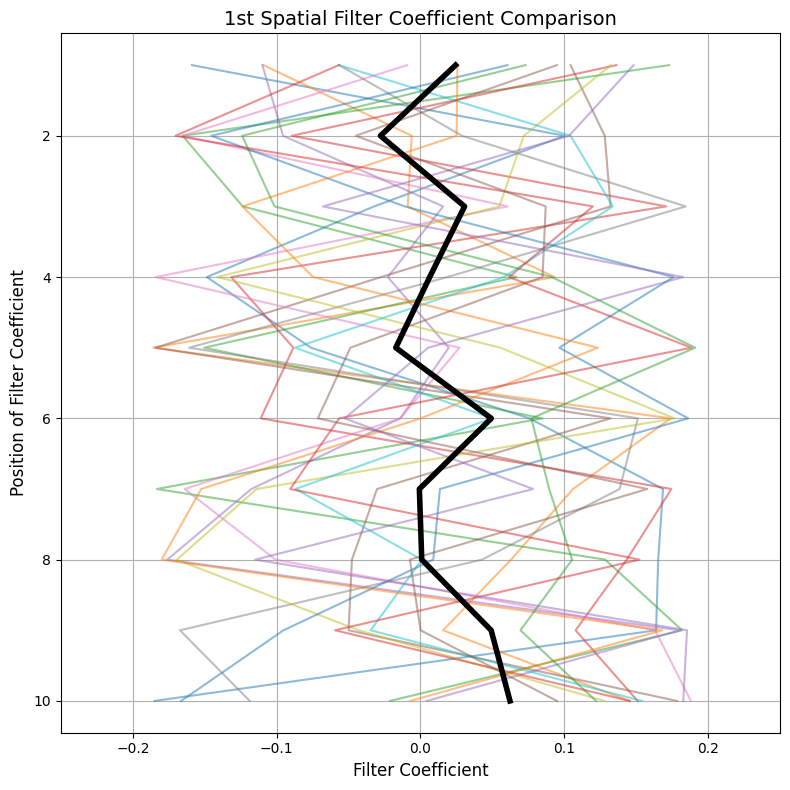

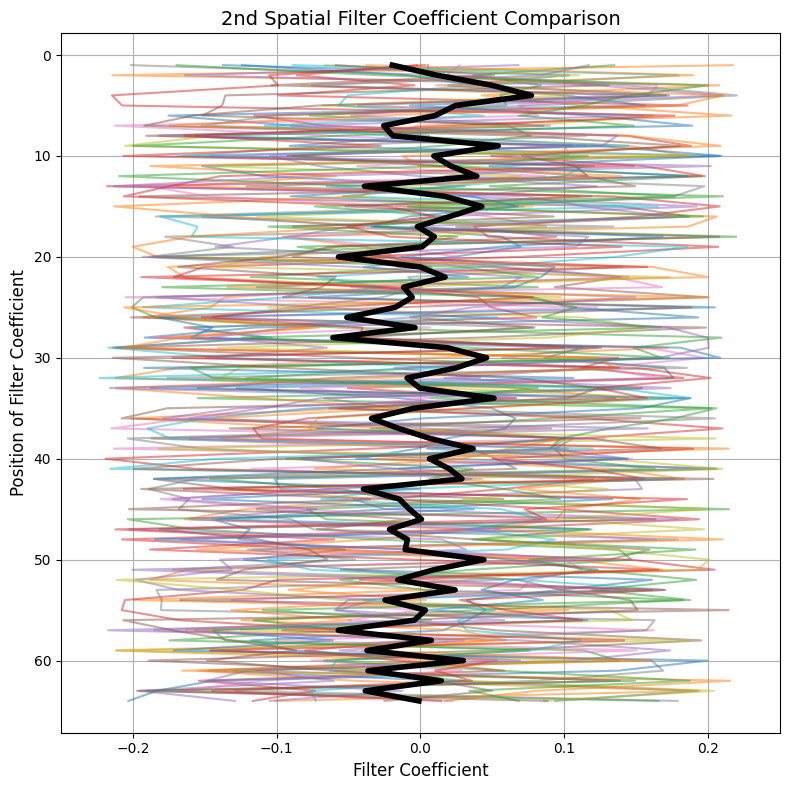

In [29]:
# 모델 로드
model = load_model('best_model_fold_3.h5')

# 첫 번째 공간 블록 필터 추출 (첫 번째 Conv2D 레이어)
first_spatial_filters = model.layers[0].get_weights()[0]  # Conv2D의 가중치
first_spatial_filters = first_spatial_filters.reshape(first_spatial_filters.shape[-1], -1)  # (num_filters, filter_length)

# 두 번째 공간 블록 필터 추출 (두 번째 Conv2D 레이어)
second_spatial_filters = model.layers[3].get_weights()[0]  # Conv2D의 가중치
second_spatial_filters = second_spatial_filters.reshape(second_spatial_filters.shape[-1], -1)  # (num_filters, filter_length)

# 평균 필터 계수 계산
first_avg_filter = np.mean(first_spatial_filters, axis=0)
second_avg_filter = np.mean(second_spatial_filters, axis=0)

# 필터 포지션 생성
position_first = np.arange(1, first_spatial_filters.shape[1] + 1)
position_second = np.arange(1, second_spatial_filters.shape[1] + 1)

# Fig. 4: 첫 번째 공간 블록 필터 계수 플롯
plt.figure(figsize=(8, 8))
for i in range(first_spatial_filters.shape[0]):
    plt.plot(first_spatial_filters[i], position_first, alpha=0.5)  # 각 필터를 플롯
plt.plot(first_avg_filter, position_first, color='black', linewidth=4)  # 평균 필터
plt.title('1st Spatial Filter Coefficient Comparison', fontsize=14)
plt.xlabel('Filter Coefficient', fontsize=12)
plt.ylabel('Position of Filter Coefficient', fontsize=12)
plt.xlim([-0.25, 0.25])
plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Fig. 5: 두 번째 공간 블록 필터 계수 플롯
plt.figure(figsize=(8, 8))
for i in range(second_spatial_filters.shape[0]):
    plt.plot(second_spatial_filters[i], position_second, alpha=0.5)  # 각 필터를 플롯
plt.plot(second_avg_filter, position_second, color='black', linewidth=4)  # 평균 필터
plt.title('2nd Spatial Filter Coefficient Comparison', fontsize=14)
plt.xlabel('Filter Coefficient', fontsize=12)
plt.ylabel('Position of Filter Coefficient', fontsize=12)
plt.xlim([-0.25, 0.25])
plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


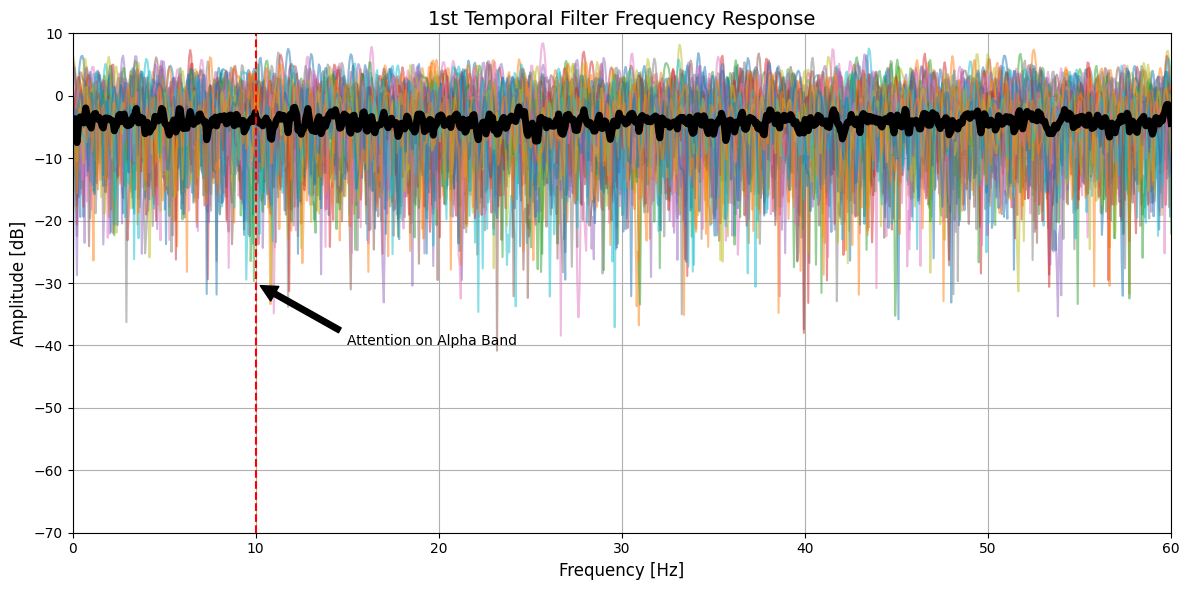

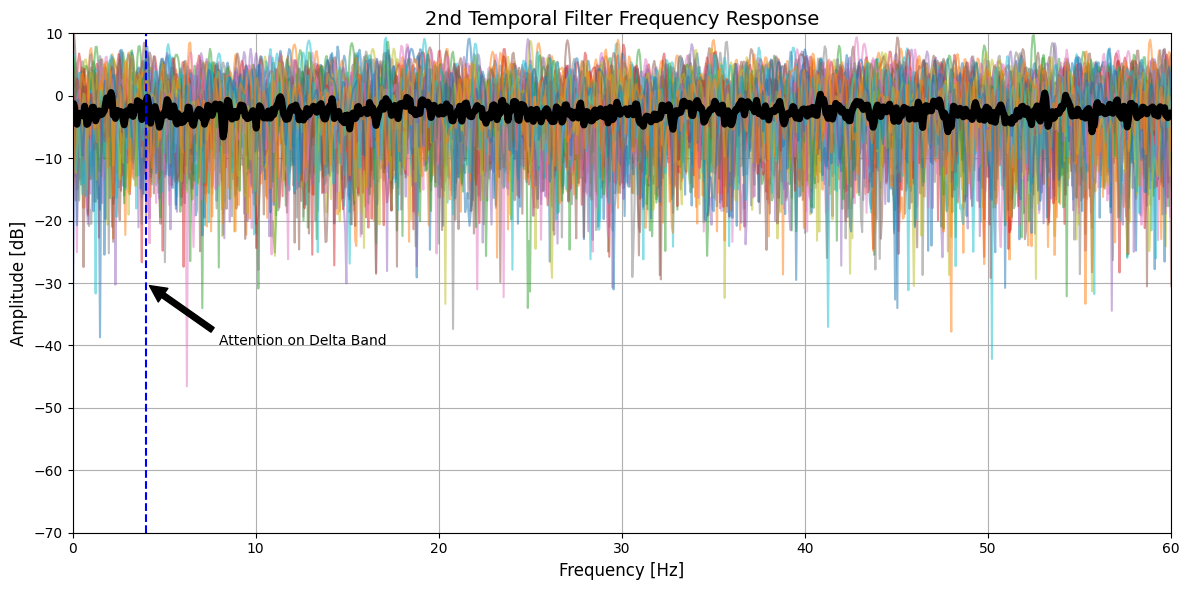

In [36]:
# 모델 로드
model = load_model('best_model_fold_4.h5')

# 첫 번째 시간 블록 필터 추출
first_temporal_filters = model.layers[6].get_weights()[0]  # 첫 번째 시간 블록의 Conv2D 레이어
first_temporal_filters = first_temporal_filters.reshape(first_temporal_filters.shape[-1], -1)  # (num_filters, filter_length)

# 두 번째 시간 블록 필터 추출
second_temporal_filters = model.layers[9].get_weights()[0]  # 두 번째 시간 블록의 Conv2D 레이어
second_temporal_filters = second_temporal_filters.reshape(second_temporal_filters.shape[-1], -1)  # (num_filters, filter_length)

# 주파수 응답 계산
num_first_filters = first_temporal_filters.shape[0]
num_second_filters = second_temporal_filters.shape[0]
frequencies = np.linspace(0, 60, 1000)  # 주파수 범위 설정 (0 Hz ~ 60 Hz)
first_amplitude_response = np.zeros((num_first_filters, len(frequencies)))
second_amplitude_response = np.zeros((num_second_filters, len(frequencies)))

# 첫 번째 시간 블록 주파수 응답
for i in range(num_first_filters):
    w, h = freqz(first_temporal_filters[i], worN=frequencies, fs=512)  # 샘플링 주파수 512 Hz
    first_amplitude_response[i] = 20 * np.log10(abs(h))  # dB로 변환

# 두 번째 시간 블록 주파수 응답
for i in range(num_second_filters):
    w, h = freqz(second_temporal_filters[i], worN=frequencies, fs=512)  # 샘플링 주파수 512 Hz
    second_amplitude_response[i] = 20 * np.log10(abs(h))  # dB로 변환

# 평균 필터 응답 계산
first_avg_response = np.mean(first_amplitude_response, axis=0)
second_avg_response = np.mean(second_amplitude_response, axis=0)

# Fig. 6: 첫 번째 시간 블록 필터 주파수 응답 플롯
plt.figure(figsize=(12, 6))
for i in range(num_first_filters):
    plt.plot(frequencies, first_amplitude_response[i], alpha=0.5)  # 각 필터를 플롯
plt.plot(frequencies, first_avg_response, color='black', linewidth=5)  # 평균 필터 응답
plt.title('1st Temporal Filter Frequency Response', fontsize=14)
plt.xlabel('Frequency [Hz]', fontsize=12)
plt.ylabel('Amplitude [dB]', fontsize=12)
plt.xlim([0, 60])  # 주파수 범위
plt.ylim([-70, 10])  # Amplitude 범위
plt.grid()
plt.axvline(x=10, color='red', linestyle='--')  # 강조 표시
plt.annotate('Attention on Alpha Band', xy=(10, -30), xytext=(15, -40),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, color='black')
plt.tight_layout()
plt.show()

# Fig. 8: 두 번째 시간 블록 필터 주파수 응답 플롯
plt.figure(figsize=(12, 6))
for i in range(num_second_filters):
    plt.plot(frequencies, second_amplitude_response[i], alpha=0.5)  # 각 필터를 플롯
plt.plot(frequencies, second_avg_response, color='black', linewidth=5)  # 평균 필터 응답
plt.title('2nd Temporal Filter Frequency Response', fontsize=14)
plt.xlabel('Frequency [Hz]', fontsize=12)
plt.ylabel('Amplitude [dB]', fontsize=12)
plt.xlim([0, 60])  # 주파수 범위
plt.ylim([-70, 10])  # Amplitude 범위
plt.grid()
plt.axvline(x=4, color='blue', linestyle='--')  # 델타 밴드 강조 표시
plt.annotate('Attention on Delta Band', xy=(4, -30), xytext=(8, -40),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, color='black')
plt.tight_layout()
plt.show()
